In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.optimize import curve_fit
import Setup as p

from astropy.io import fits

In [3]:
# Load the data
data = np.loadtxt("../../Data/SMmatching/LF_Ser.dat")
cat = fits.open("../../BAM/Old/nsa_v1.fits")[1].data

In [4]:
# Our chosen definition of little h
h = 0.688

# Take the r-band absolute magnitude and eliminate galaxies with no stellar mass estimate
absmag = cat['SERSIC_ABSMAG'][:, 4]-5*np.log10(h)
mass = cat['SERSIC_MASS']
IDS = np.where(np.isfinite(mass))
logmass = np.log10(mass[IDS])-2*np.log10(h)
absmag = absmag[IDS]

#Some arbitrary cut on stellar mass
IDS = np.where(logmass > 10.2)
logmass = logmass[IDS]
absmag = absmag[IDS]
print(absmag.size)


IDS = np.where(np.logical_and(absmag>-23, absmag<-18.4))
print(absmag.size-IDS[0].size)
logmass = logmass[IDS]
absmag = absmag[IDS]


460930
3587


/mnt/zfsusers/rstiskalek/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


In [5]:
np.min(absmag), np.max(absmag)

(-22.99888, -18.403124)

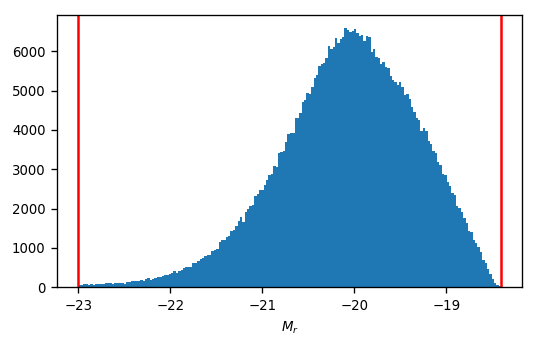

In [6]:
plt.figure(dpi=120, figsize=(5, 3))
plt.rcParams.update({'font.size': 8})
plt.hist(absmag, bins='auto', log=False)
plt.axvline(x=-23, c='red')
plt.axvline(x=-18.4, c='red')
plt.xlabel(r"$M_r$")
plt.savefig("../../Plots/NSA_Mr_hist.png", dpi=240)
plt.show()

In [10]:
10**y

array([  5.18800039e-07,   1.37720947e-06,   3.03389118e-06,
         6.90239804e-06,   1.25025903e-05,   2.23357222e-05,
         3.88150366e-05,   6.76082975e-05,   1.11429453e-04,
         1.77418948e-04,   2.78612117e-04,   4.13999675e-04,
         5.90201080e-04,   8.03526122e-04,   1.06905488e-03,
         1.33045442e-03,   1.58124804e-03,   1.89670592e-03,
         2.14783047e-03,   2.48885732e-03,   2.76057786e-03,
         3.09741930e-03,   3.20626932e-03,   3.25836701e-03,
         3.33426413e-03,   3.53997341e-03,   3.57272838e-03,
         3.89941987e-03,   3.99024902e-03,   4.19758984e-03,
         4.25598413e-03,   4.48745390e-03,   4.95450191e-03,
         4.90907876e-03,   4.62381021e-03,   4.46683592e-03])

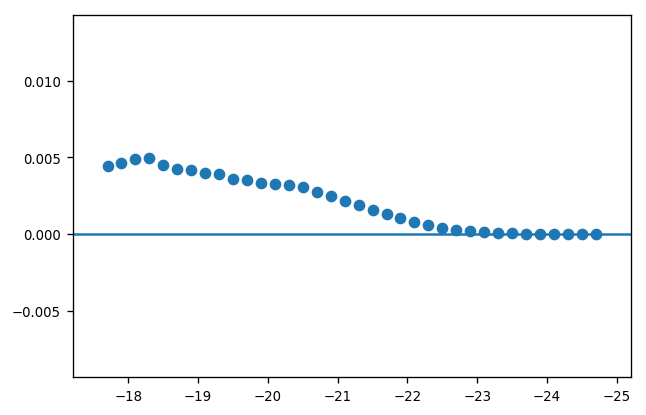

In [9]:
x = data[:, 0]
y = data[:, 1]
t = np.linspace(x.min(), x.max())

# Interpolate the galaxy luminosity function
nlum = interp1d(x, y, kind='cubic', fill_value='extrapolate')

plt.figure(dpi=120)
plt.scatter(x,10**y, marker='o')
# plt.plot(t, nlum(t), c='red')
plt.axhline(0)
plt.xlim(np.max(x)+0.5, np.min(x)-0.5)
plt.show()

In [157]:
def bright_end_func(x, a, b, c, d):
    return -np.exp(a*x+b) + c*x + d

def faint_end_func(x, a, b):
    return a*x+b

bright_end_coef = curve_fit(bright_end_func, x[:27], y[:27], [[1, 0, 0, 0]], maxfev=100000)[0]
s = slice(-5, None)
faint_end_coef = curve_fit(faint_end_func, x[s], y[s], [0, 0], maxfev=100000)[0]

/mnt/zfsusers/rstiskalek/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


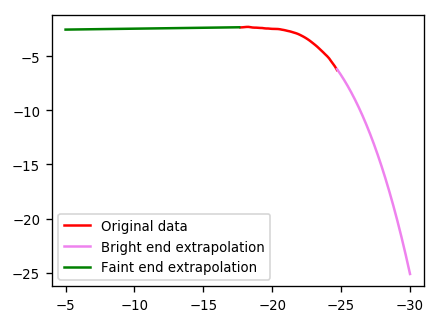

In [158]:
tbright = np.linspace(-24.7, -30, 250)
a, b, c, d = bright_end_coef
ybright = [bright_end_func(i, a, b, c, d) for i in tbright]

tfaint=np.linspace(-17.6, -5, 100)
a, b = faint_end_coef
yfaint = [faint_end_func(i, a, b) for i in tfaint]

y = nlum(t)

plt.figure(figsize=(4,3), dpi=120)
# plt.scatter(x,y, s=15, marker='x')
plt.rcParams.update({'font.size': 8})
plt.plot(t, y, c='red', label='Original data')
plt.plot(tbright, ybright, c='violet', label='Bright end extrapolation')
plt.plot(tfaint, yfaint, c='green', label='Faint end extrapolation')
plt.xlim(-4, -31)
plt.legend()
plt.savefig("../../Plots/GalLumExtrapolate.png", dpi=240)
plt.show()

In [159]:
xx = np.hstack([tfaint, t, tbright])
yy = np.hstack([yfaint, y, ybright])

IDS = np.argsort(xx)
xx = xx[IDS]
yy = yy[IDS]

IDS = np.unique(xx, return_index=True)[1]
xx = xx[IDS]
yy = yy[IDS]


nlum = interp1d(xx, yy, kind='cubic')

h = np.linspace(xx.min(), xx.max(), 10000)

plt.figure(dpi=120)
# plt.scatter(x,y, s=15, marker='x')
plt.rcParams.update({'font.size': 8})
plt.plot(h, nlum(h))
plt.xlim(xx.max()+1, xx.min()-1)
plt.show()

In [161]:
def absmag_dist(d):
    # Distance in Mpc
    appmag_lim = 17.6
    return appmag_lim -25 -  5*np.log10(d)

faintest_absmag = np.max(absmag)
brightest_absmag = np.min(absmag)

faintest_absmag, brightest_absmag

faintest_absmag, absmag_dist(25)

In [164]:
norm = quad(nlum, faintest_absmag, brightest_absmag)[0]
def surv_dist(d):
    sdsslim = absmag_dist(d)
    # If SDSS lim is less bright than faintest sdss object return 1.0
    if sdsslim > faintest_absmag:
        return 1.0
    else:
        integ = quad(nlum, sdsslim, brightest_absmag, limit=100, epsabs=1.49e-5)
        if integ[1] > 1e-3:
            print("Hmm, having problems")
    return integ[0]/norm



In [165]:
xx = np.linspace(1, 220, 100)
yy = np.array([surv_dist(i) for i in xx])

plt.figure(dpi=120, figsize=(5,3))
plt.rcParams.update({'font.size': 8})
plt.plot(xx, yy)
plt.grid()
plt.xlabel(r"$d\ [\mathrm{Mpc}$]")
plt.ylabel(r"$\varphi(d)$")
plt.savefig("../../Plots/SDSSsurv.png", dpi=240)
plt.show()